In [12]:
pip install yfinance

In [13]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime as dt
import math
from numpy.random import choice
import random
import yfinance as yf
import math

#Import Model Packages for reinforcement learning
from keras import layers, models, optimizers
from keras import backend as K
from collections import namedtuple, deque
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')



In [14]:
# Technical Indicator Function

def MACD(data, period_short=12, period_long=26, signal=9):
    ShortEMA = data.Close.ewm(span=period_short, adjust=False).mean()
    LongEMA = data.Close.ewm(span=period_long, adjust=False).mean()
    MACD = ShortEMA - LongEMA
    SignalLine = MACD.ewm(span=signal, adjust=False).mean()
    return MACD

def CCI(data, n=20):
    TP = (data.High + data.Low + data.Close) / 3
    CCI = pd.Series((TP - TP.rolling(n).mean()) / (0.015 * TP.rolling(n).std()), name='CCI')
    return CCI

def RSI(data, period=14):
    delta = data.Close.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

def StochasticOscillator(data, k_period=14, d_period=3):
    L14 = data.Low.rolling(window=k_period).min()
    H14 = data.High.rolling(window=k_period).max()
    K = 100 * ((data.Close - L14) / (H14 - L14))
    D = K.rolling(window=d_period).mean()
    signal = K/D
    return signal

def VWAP(data):
    return (data.Volume * (data.High + data.Low + data.Close) / 3).cumsum() / data.Volume.cumsum()


In [15]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from IPython.core.debugger import set_trace

import numpy as np
import random
from collections import deque

class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        #State size depends and is equal to the the window size, n previous days
        self.state_size = state_size # normalized previous days,
        self.action_size = 3 # sit, buy, sell
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        #self.epsilon_decay = 0.9

        #self.model = self._model()

        self.model = load_model(model_name) if is_eval else self._model()

    #Deep Q Learning model- returns the q-value when given state as input
    def _model(self):
        model = Sequential()
        #Input Layer
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        #Hidden Layers
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        #Output Layer
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))
        return model

    #Return the action on the value function
    #With probability (1-$\epsilon$) choose the action which has the highest Q-value.
    #With probability ($\epsilon$) choose any action at random.
    #Intitially high epsilon-more random, later less
    #The trained agents were evaluated by different initial random condition
    #and an e-greedy policy with epsilon 0.05. This procedure is adopted to minimize the possibility of overfitting during evaluation.

    def act(self, state):
        #If it is test and self.epsilon is still very high, once the epsilon become low, there are no random
        #actions suggested.
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        options = self.model.predict(state)
        return np.argmax(options[0])

    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])

        # the memory during the training phase.
        for state, action, reward, next_state, done in mini_batch:
            target = reward # reward or Q at time t
            #update the Q table based on Q table equation
            #set_trace()
            if not done:
                #set_trace()
                #max of the array of the predicted.
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

            # Q-value of the state currently from the table
            target_f = self.model.predict(state)
            # Update the output Q table for the given action in the table
            target_f[0][action] = target
            #train and fit the model where state is X and target_f is Y, where the target is updated.
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [16]:
# prints formatted price
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))


def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# returns an an n-day state representation ending at time t

def getState(data, t, n, window_size=3):
    # Ensure that we have enough data points to calculate indicators
    if t - n < 0:
        raise ValueError("Not enough data points to calculate state")

    # Extracting the subset of data needed for this state
    d = t - n + 1
    block = data[d:t + 1]

    # Calculate technical indicators
    # Note: These functions should be defined as previously explained
    macd = MACD(block)
    cci = CCI(block)
    rsi = RSI(block)
    stochastic_k = StochasticOscillator(block)
    vwap = VWAP(block)

    # Normalizing or processing the indicators as required
    state = [
        sigmoid(block['Close'].iloc[-1] - block['Close'].iloc[-2]),  # Price change as before
        macd.iloc[-1],  # Latest MACD value
        cci.iloc[-1],  # Latest CCI value
        rsi.iloc[-1],  # Latest RSI value
        stochastic_k.iloc[-1],  # Latest Stochastic %K value
        vwap.iloc[-1]  # Latest VWAP value
    ]

    # Ensure the state is in the format expected by the model
    return np.array([state])

image = 1
# Plots the behavior of the output
def plot_behavior(data_input, states_buy, states_sell, profit,e):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='r', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='m', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='k', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()

    plt.savefig(str(e) + '.png')
    plt.show()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step
122
1/1 [==============================] - 0s 30ms/step
123
1/1 [==============================] - 0s 27ms/step
124
1/1 [==============================] - 0s 64ms/step
125
1/1 [==============================] - 0s 24ms/step
126
1/1 [==============================] - 0s 23ms/step
127
1/1 [==============================] - 0s 25ms/step
128
1/1 [==============================] - 0s 28ms/step
129
1/1 [==============================] - 0s 47ms/step
130
1/1 [==============================] - 0s 31ms/step
131
1/1 [==============================] - 0s 25ms/step
132
1/1 [==============================] - 0s 25ms/step
133
1/1 [==============================] - 0s 23ms/step
134
1/1 [==============================] - 0s 30ms/step
135
1/1 [==============================] - 0s 45ms/step
136
1/1 [==============================] - 0s 29ms/step
137
1/1 [==============================] - 0s 28ms/step
1

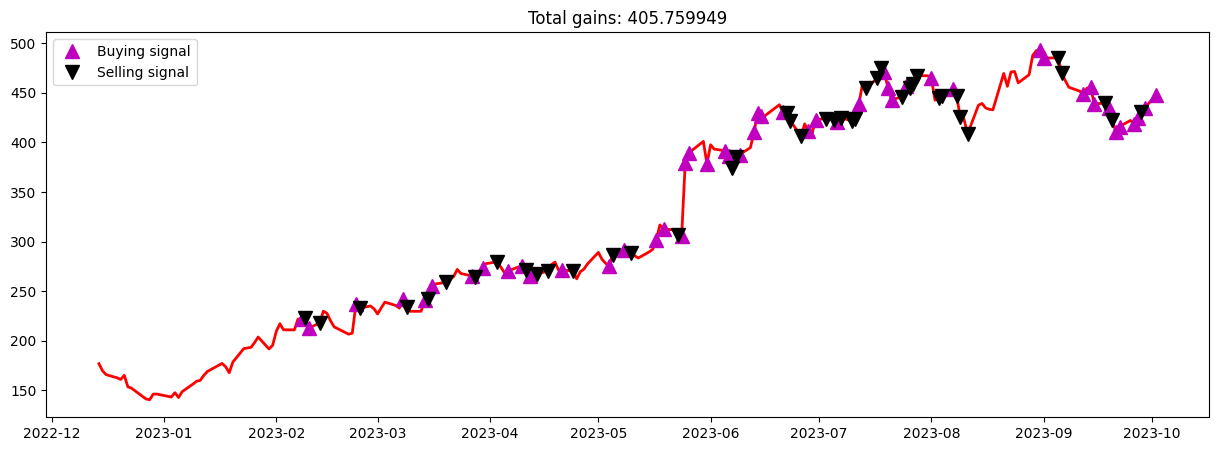

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 24ms/step
122
1/1 [==============================] - 0s 24ms/step
123
1/1 [==============================] - 0s 27ms/step
124
1/1 [==============================] - 0s 33ms/step
125
1/1 [==============================] - 0s 51ms/step
126
1/1 [==============================] - 0s 60ms/step
127
1/1 [==============================] - 0s 27ms/step
128
1/1 [==============================] - 0s 32ms/step
129
1/1 [==============================] - 0s 34ms/step
130
1/1 [==============================] - 0s 32ms/step
131
1/1 [==============================] - 0s 42ms/step
132
1/1 [==============================] - 0s 32ms/step
133
1/1 [==============================] - 0s 29ms/step
134
1/1 [==============================] - 0s 32ms/step
135
1/1 [==============================] - 0s 36ms/step
136
1/1 [==============================] - 0s 29ms/step
137
1/1 [==============================] - 0s 28ms/step
1

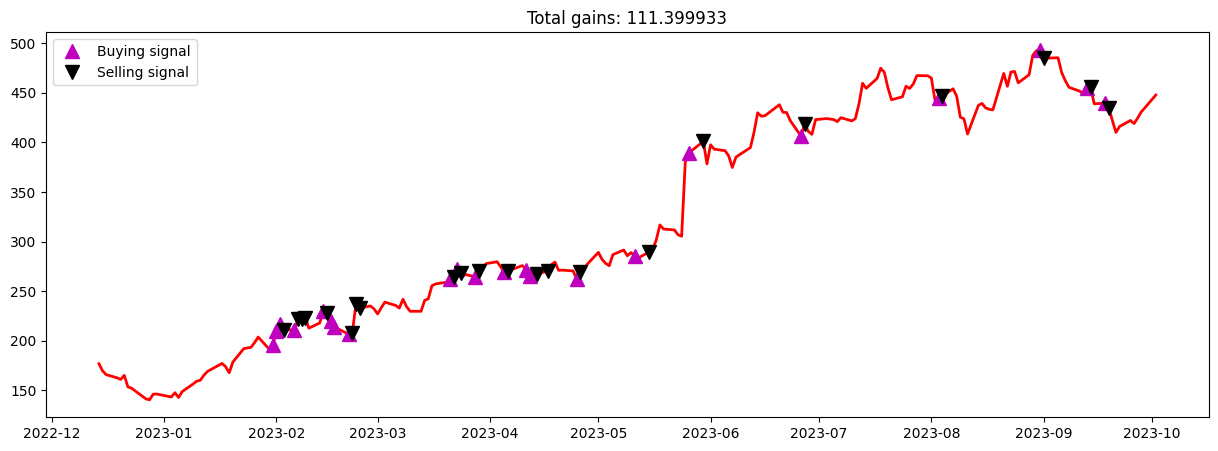

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 29ms/step
122
1/1 [==============================] - 0s 39ms/step
123
1/1 [==============================] - 0s 27ms/step
124
1/1 [==============================] - 0s 32ms/step
125
1/1 [==============================] - 0s 28ms/step
126
1/1 [==============================] - 0s 34ms/step
127
1/1 [==============================] - 0s 50ms/step
128
1/1 [==============================] - 0s 54ms/step
129
1/1 [==============================] - 0s 37ms/step
130
1/1 [==============================] - 0s 28ms/step
131
1/1 [==============================] - 0s 29ms/step
132
1/1 [==============================] - 0s 31ms/step
133
1/1 [==============================] - 0s 25ms/step
134
1/1 [==============================] - 0s 32ms/step
135
1/1 [==============================] - 0s 31ms/step
136
1/1 [==============================] - 0s 26ms/step
137
1/1 [==============================] - 0s 34ms/step
1

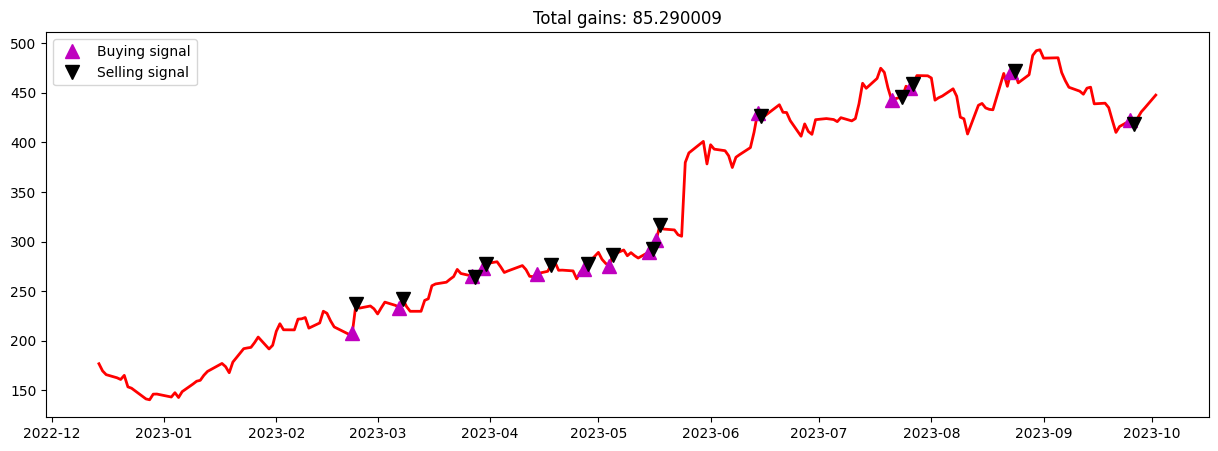

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 39ms/step
122
1/1 [==============================] - 0s 33ms/step
123
1/1 [==============================] - 0s 33ms/step
124
1/1 [==============================] - 0s 33ms/step
125
1/1 [==============================] - 0s 32ms/step
126
1/1 [==============================] - 0s 40ms/step
127
1/1 [==============================] - 0s 34ms/step
128
1/1 [==============================] - 0s 30ms/step
129
1/1 [==============================] - 0s 26ms/step
130
1/1 [==============================] - 0s 33ms/step
131
1/1 [==============================] - 0s 60ms/step
132
1/1 [==============================] - 0s 35ms/step
133
1/1 [==============================] - 0s 34ms/step
134
1/1 [==============================] - 0s 33ms/step
135
1/1 [==============================] - 0s 37ms/step
136
1/1 [==============================] - 0s 33ms/step
137
1/1 [==============================] - 0s 36ms/step
1

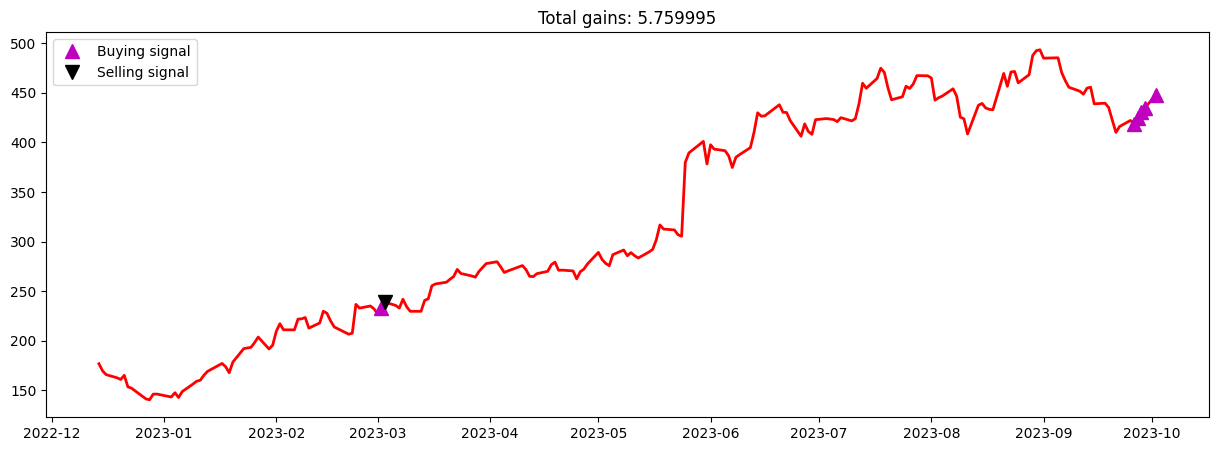

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 40ms/step
122
1/1 [==============================] - 0s 51ms/step
123
1/1 [==============================] - 0s 32ms/step
124
1/1 [==============================] - 0s 30ms/step
125
1/1 [==============================] - 0s 33ms/step
126
1/1 [==============================] - 0s 41ms/step
127
1/1 [==============================] - 0s 37ms/step
128
1/1 [==============================] - 0s 36ms/step
129
1/1 [==============================] - 0s 37ms/step
130
1/1 [==============================] - 0s 38ms/step
131
1/1 [==============================] - 0s 31ms/step
132
1/1 [==============================] - 0s 34ms/step
133
1/1 [==============================] - 0s 31ms/step
134
1/1 [==============================] - 0s 46ms/step
135
1/1 [==============================] - 0s 40ms/step
136
1/1 [==============================] - 0s 32ms/step
137
1/1 [==============================] - 0s 30ms/step
1

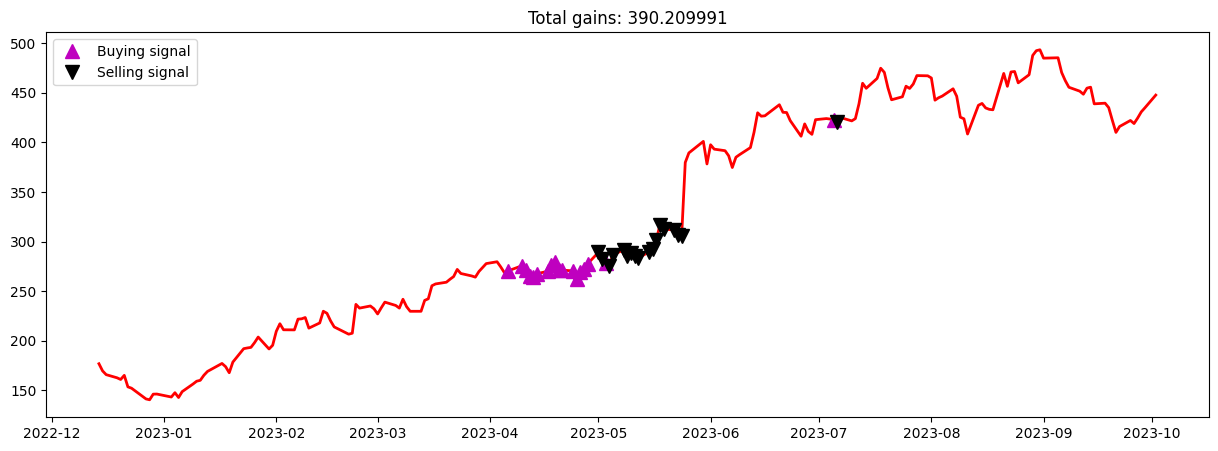

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 42ms/step
122
1/1 [==============================] - 0s 34ms/step
123
1/1 [==============================] - 0s 35ms/step
124
1/1 [==============================] - 0s 31ms/step
125
1/1 [==============================] - 0s 31ms/step
126
1/1 [==============================] - 0s 32ms/step
127
1/1 [==============================] - 0s 41ms/step
128
1/1 [==============================] - 0s 57ms/step
129
1/1 [==============================] - 0s 47ms/step
130
1/1 [==============================] - 0s 39ms/step
131
1/1 [==============================] - 0s 40ms/step
132
1/1 [==============================] - 0s 52ms/step
133
1/1 [==============================] - 0s 36ms/step
134
1/1 [==============================] - 0s 44ms/step
135
1/1 [==============================] - 0s 33ms/step
136
1/1 [==============================] - 0s 30ms/step
137
1/1 [==============================] - 0s 43ms/step
1

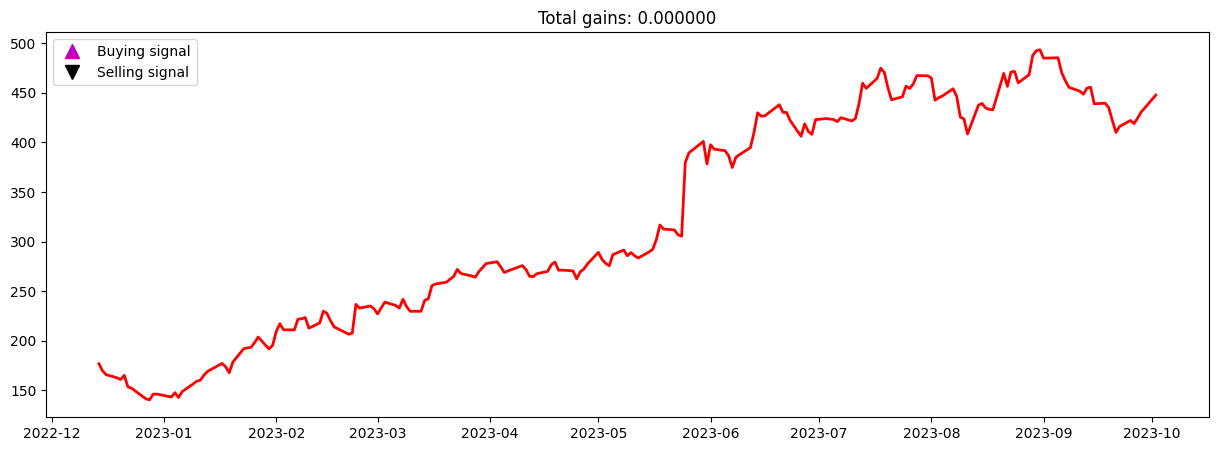

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 32ms/step
122
1/1 [==============================] - 0s 44ms/step
123
1/1 [==============================] - 0s 38ms/step
124
1/1 [==============================] - 0s 42ms/step
125
1/1 [==============================] - 0s 35ms/step
126
1/1 [==============================] - 0s 35ms/step
127
1/1 [==============================] - 0s 32ms/step
128
1/1 [==============================] - 0s 36ms/step
129
1/1 [==============================] - 0s 41ms/step
130
1/1 [==============================] - 0s 39ms/step
131
1/1 [==============================] - 0s 32ms/step
132
1/1 [==============================] - 0s 38ms/step
133
1/1 [==============================] - 0s 32ms/step
134
1/1 [==============================] - 0s 41ms/step
135
1/1 [==============================] - 0s 38ms/step
136
1/1 [==============================] - 0s 44ms/step
137
1/1 [==============================] - 0s 34ms/step
1

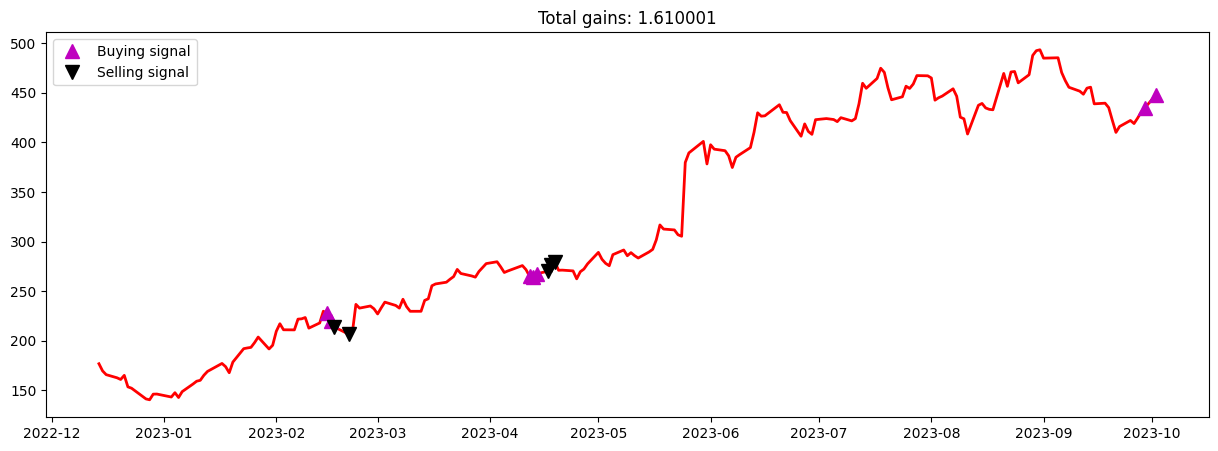

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 41ms/step
122
1/1 [==============================] - 0s 36ms/step
123
1/1 [==============================] - 0s 42ms/step
124
1/1 [==============================] - 0s 42ms/step
125
1/1 [==============================] - 0s 81ms/step
126
1/1 [==============================] - 0s 31ms/step
127
1/1 [==============================] - 0s 31ms/step
128
1/1 [==============================] - 0s 30ms/step
129
1/1 [==============================] - 0s 38ms/step
130
1/1 [==============================] - 0s 33ms/step
131
1/1 [==============================] - 0s 45ms/step
132
1/1 [==============================] - 0s 61ms/step
133
1/1 [==============================] - 0s 40ms/step
134
1/1 [==============================] - 0s 39ms/step
135
1/1 [==============================] - 0s 43ms/step
136
1/1 [==============================] - 0s 36ms/step
137
1/1 [==============================] - 0s 32ms/step
1

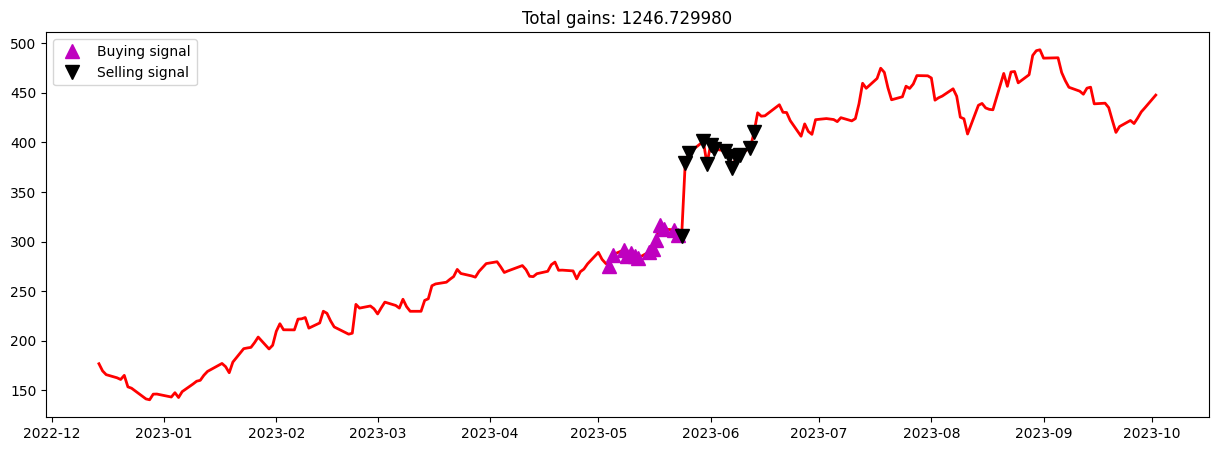

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 40ms/step
122
1/1 [==============================] - 0s 44ms/step
123
1/1 [==============================] - 0s 42ms/step
124
1/1 [==============================] - 0s 49ms/step
125
1/1 [==============================] - 0s 40ms/step
126
1/1 [==============================] - 0s 43ms/step
127
1/1 [==============================] - 0s 52ms/step
128
1/1 [==============================] - 0s 47ms/step
129
1/1 [==============================] - 0s 43ms/step
130
1/1 [==============================] - 0s 41ms/step
131
1/1 [==============================] - 0s 33ms/step
132
1/1 [==============================] - 0s 39ms/step
133
1/1 [==============================] - 0s 38ms/step
134
1/1 [==============================] - 0s 36ms/step
135
1/1 [==============================] - 0s 33ms/step
136
1/1 [==============================] - 0s 44ms/step
137
1/1 [==============================] - 0s 33ms/step
1

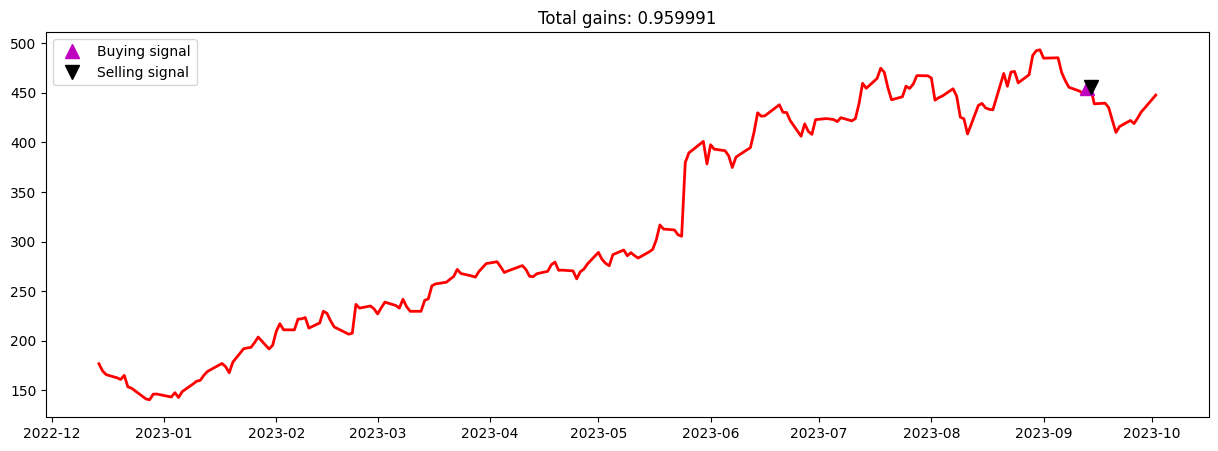

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 38ms/step
122
1/1 [==============================] - 0s 42ms/step
123
1/1 [==============================] - 0s 36ms/step
124
1/1 [==============================] - 0s 36ms/step
125
1/1 [==============================] - 0s 53ms/step
126
1/1 [==============================] - 0s 54ms/step
127
1/1 [==============================] - 0s 33ms/step
128
1/1 [==============================] - 0s 32ms/step
129
1/1 [==============================] - 0s 31ms/step
130
1/1 [==============================] - 0s 29ms/step
131
1/1 [==============================] - 0s 47ms/step
132
1/1 [==============================] - 0s 52ms/step
133
1/1 [==============================] - 0s 38ms/step
134
1/1 [==============================] - 0s 39ms/step
135
1/1 [==============================] - 0s 35ms/step
136
1/1 [==============================] - 0s 36ms/step
137
1/1 [==============================] - 0s 44ms/step
1

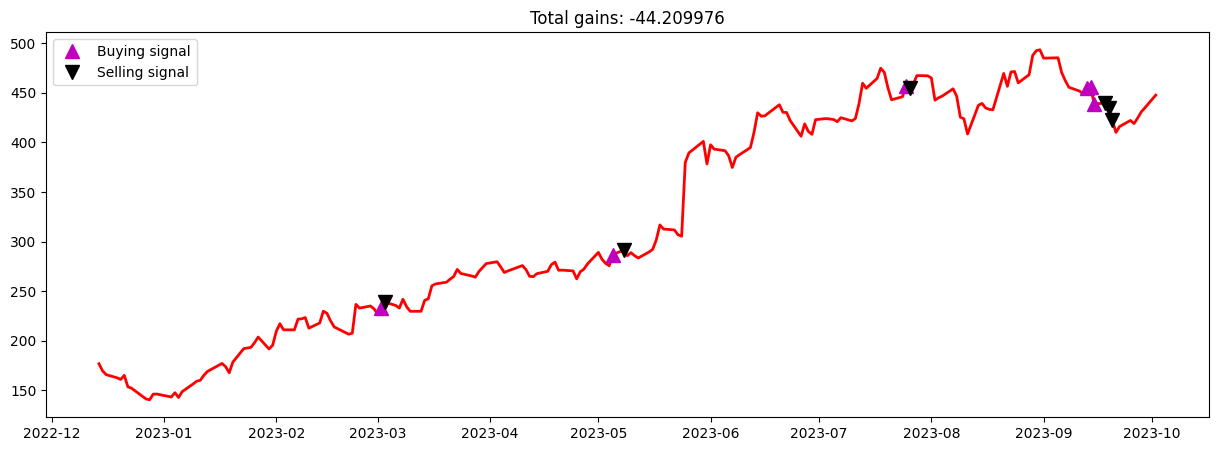

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 40ms/step
116
1/1 [==============================] - 0s 38ms/step
117
1/1 [==============================] - 0s 33ms/step
118
1/1 [==============================] - 0s 36ms/step
119
1/1 [==============================] - 0s 30ms/step
120
1/1 [==============================] - 0s 41ms/step
121
1/1 [==============================] - 0s 38ms/step
122
1/1 [==============================] - 0s 42ms/step
123
1/1 [==============================] - 0s 33ms/step
124
1/1 [==============================] - 0s 39ms/step
125
1/1 [==============================] - 0s 55ms/step
126
1/1 [==============================] - 0s 65ms/step
127
1/1 [==============================] - 0s 42ms/step
128
1/1 [==============================] - 0s 50ms/step
129
1/1 [==============================] - 0s 38ms/step
130
1/1 [==============================] - 0s 46ms/step
131
1/1 [==============================] - 0s 31ms/step
1

In [ ]:
ticker = "NVDA"
dataset = yf.download(ticker, dt.date.today() - dt.timedelta(365), dt.datetime.today(), interval="1d")

# Handle missing values
dataset = dataset.fillna(method='ffill')

# Splitting the data into train and test sets
validation_size = 0.2
train_size = int(len(dataset) * (1 - validation_size))
X_train, X_test = dataset[0:train_size], dataset[train_size:len(dataset)]

# Setting up the trading environment
window_size = 30
agent = Agent(6)
data = X_train
l = len(data) - 1
batch_size = 32
episode_count = 10

# Trading loop
for e in range(episode_count + 1):
    print("Running episode " + str(e) + "/" + str(episode_count))
    total_profit = 0
    agent.inventory = []
    states_sell = []
    states_buy = []

    for i in range(window_size, l):
        print(i)
        t = i
        state = getState(data, t, window_size)
        action = agent.act(state)
        next_state = getState(data, t + 1, window_size)
        reward = 0

        # Implement buy and sell logic
        if action == 1: # buy
            agent.inventory.append(data.iloc[t])  # Use .iloc to access the row
            states_buy.append(t)
            #print("Buy: " + formatPrice(data['Close'][t]))

        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = agent.inventory.pop(0)['Close']  # Access the 'Close' price
            reward = max(data['Close'][t] - bought_price, 0)
            total_profit += data['Close'][t] - bought_price
            states_sell.append(t)

        # Update state, handle inventory, calculate reward
        done = True if i == l - 1 else False
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        # Experience replay
        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)

        # Save the model at specified intervals
        if e % 2 == 0:
            agent.model.save("model_ep" + str(e))

        # Display total profit at the end of each episode
        if i == l - 1:
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("--------------------------------")
            plot_behavior(data['Close'][0:l], states_buy, states_sell, total_profit,e)
